# dcgan

In [1]:
import numpy as np

data = np.load('data/electrons_log', encoding='latin1')

In [7]:
data = np.load('data/electrons_log', encoding='latin1')
real_data = np.exp(data)
tanh_data = np.tanh(real_data)

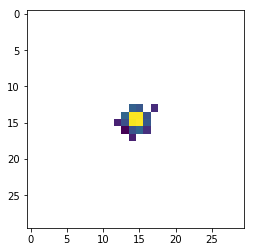

In [3]:
import scipy.misc
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure()
plt.imshow(data[0])

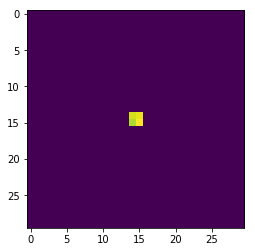

In [4]:
plt.figure()
plt.imshow(real_data[0])

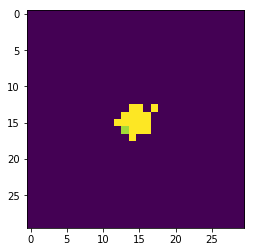

In [5]:
tanh_data = np.tanh(real_data)

plt.figure()
plt.imshow(tanh_data[0])

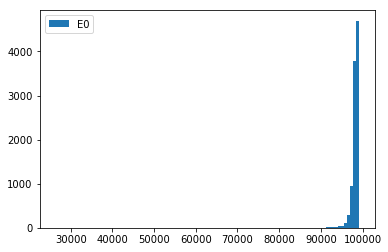

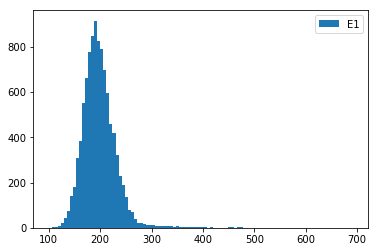

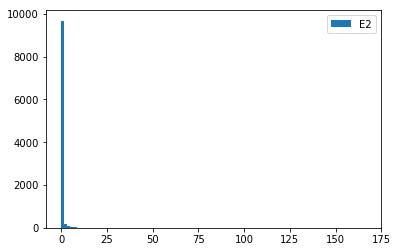

In [6]:
E, E_first, E_second = np.zeros(10000), np.zeros(10000), np.zeros(10000)

for i in range(10000):
    E[i] = np.exp(data[i][14][14]) +  np.exp(data[i][15][14]) + np.exp(data[i][14][15]) + np.exp(data[i][15][15])
    for j in range(4):
        for k in range(4):
            if (j == 0 or j == 3 or k == 0 or k == 3):
                 E_first[i] += np.exp(data[i][13+j][13+k])
            if (j == 0 or j == 7 or k == 0 or k == 7):
                 E_second[i] += np.exp(data[i][11+j][11+k])
                    
plt.hist(E, 100, label='E0')
plt.legend(loc='best')
plt.show()
plt.hist(E_first, 100, label='E1')
plt.legend(loc='best')
plt.show()
plt.hist(E_second, 100, label='E2')
plt.legend(loc='best')
plt.show()

In [5]:
from __future__ import print_function, division
from IPython import display

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, InputLayer
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, UpSampling3D, Conv2D, Deconv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import backend as K

import sys

import tensorflow as tf

Using TensorFlow backend.


epoch 1650


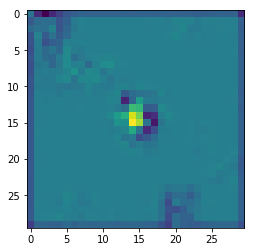

KeyboardInterrupt: 

In [11]:
class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 30
        self.img_cols = 30
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 5 * 5, activation="relu", input_shape=(self.latent_dim,)))
        model.add(Reshape((5, 5, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D(size=(3, 3)))
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

#        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

#        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):
        # Rescale -1 to 1
        X_train = tanh_data
        #X_train = (X_train.astype(np.float32) - 127.5)/127.5
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            # Sample noise and generate a half batch of new images
            noise = np.random.normal(0, 1, (half_batch, 100))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Sample generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, np.ones((batch_size, 1)))

            # Plot the progress
            #print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
                
    

    def save_imgs(self, epoch):
        display.clear_output()
        print("epoch", epoch)
        noise = np.random.normal(0, 1, (1, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
#        gen_imgs = 0.5 * gen_imgs + 1
#        fig, axs = plt.subplots(1, 1, figsize=(7,7))
        plt.imshow(np.arctanh(gen_imgs[0, :,:,0]))
        plt.show()
#        plt.close()


if __name__ == '__main__':
    dcgan = DCGAN()
    dcgan.train(epochs=50000, batch_size=32, save_interval=50)

In [15]:
noise_shape = 100
#img_shape = (30, 30, 1)
dropout = 0.3
leak_slope = 0.2
K.set_learning_phase(1)

epoch 350


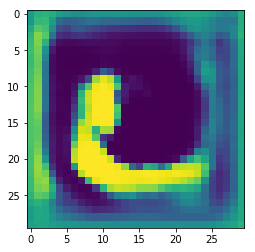

KeyboardInterrupt: 

In [17]:
class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 30
        self.img_cols = 30
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        generator = Sequential()
    
        generator.add(InputLayer(input_shape=[noise_shape]))
        generator.add(Dense(7 * 7))
        generator.add(BatchNormalization())
        generator.add(LeakyReLU(leak_slope))
        generator.add(Reshape((7, 7, 1)))
        generator.add(Deconv2D(128, kernel_size=(5, 5)))
        generator.add(BatchNormalization())
        generator.add(LeakyReLU(leak_slope))
        generator.add(Deconv2D(128, kernel_size=(5, 5)))
        generator.add(BatchNormalization())
        generator.add(LeakyReLU(leak_slope))
        generator.add(Deconv2D(64, kernel_size=(5, 5)))
        generator.add(BatchNormalization())
        generator.add(LeakyReLU(leak_slope))
        generator.add(Deconv2D(64, kernel_size=(5, 5)))
        generator.add(BatchNormalization())
        generator.add(LeakyReLU(leak_slope))
        generator.add(Deconv2D(32, kernel_size=(4, 4)))
        generator.add(BatchNormalization())
        generator.add(LeakyReLU(leak_slope))
        generator.add(Deconv2D(32, kernel_size=(4, 4)))
        generator.add(BatchNormalization())
        generator.add(LeakyReLU(leak_slope))
        generator.add(Deconv2D(16, kernel_size=(4, 4)))
        generator.add(BatchNormalization())
        generator.add(LeakyReLU(leak_slope))
        generator.add(Conv2D(1, kernel_size=(3, 3), activation='tanh'))

        generator.summary()

        noise = Input(shape=(self.latent_dim,))
        img = generator(noise)

        return Model(noise, img)

    def build_discriminator(self):

        discriminator = Sequential()
    
        discriminator.add(InputLayer(self.img_shape))
        discriminator.add(Conv2D(32, kernel_size=(3, 3), strides=2))
        discriminator.add(LeakyReLU(leak_slope))
        discriminator.add(Conv2D(32, kernel_size=(3, 3)))
        discriminator.add(BatchNormalization())
        discriminator.add(LeakyReLU(leak_slope))
        discriminator.add(Conv2D(64, kernel_size=(3, 3)))
        discriminator.add(BatchNormalization())
        discriminator.add(LeakyReLU(leak_slope))
        discriminator.add(Conv2D(64, kernel_size=(3, 3), strides=2))
        discriminator.add(BatchNormalization())
        discriminator.add(LeakyReLU(leak_slope))
        discriminator.add(Conv2D(128, kernel_size=(3, 3)))
        discriminator.add(BatchNormalization())
        discriminator.add(LeakyReLU(leak_slope))
        discriminator.add(Flatten())
        discriminator.add(Dense(256))
        discriminator.add(BatchNormalization())
        discriminator.add(Activation('tanh'))
        discriminator.add(Dense(1, activation='sigmoid'))
        discriminator.summary()

        img = Input(shape=self.img_shape)
        validity = discriminator(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):
        # Rescale -1 to 1
        X_train = tanh_data
        #X_train = (X_train.astype(np.float32) - 127.5)/127.5
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            # Sample noise and generate a half batch of new images
            noise = np.random.normal(0, 1, (half_batch, 100))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Sample generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, np.ones((batch_size, 1)))

            # Plot the progress
            #print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        display.clear_output()
        print("epoch", epoch)
        noise = np.random.normal(0, 1, (1, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
#        gen_imgs = 0.5 * gen_imgs + 1
#        fig, axs = plt.subplots(1, 1, figsize=(7,7))
        plt.imshow(gen_imgs[0, :,:,0])
        plt.show()
#        plt.close()


if __name__ == '__main__':
    dcgan = DCGAN()
    dcgan.train(epochs=2000, batch_size=32, save_interval=50)

In [14]:
import os, time, itertools, pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

def lrelu(x, th=0.2):
    return tf.maximum(th * x, x)

# G(z)
def generator(x, isTrain=True, reuse=False):
    with tf.variable_scope('generator', reuse=reuse):

        # 1st hidden layer
        conv1 = tf.layers.conv2d_transpose(x, 1024, [4, 4], strides=(1, 1), padding='valid')
        lrelu1 = lrelu(tf.layers.batch_normalization(conv1, training=isTrain), 0.2)

        # 2nd hidden layer
        conv2 = tf.layers.conv2d_transpose(lrelu1, 512, [4, 4], strides=(2, 2), padding='same')
        lrelu2 = lrelu(tf.layers.batch_normalization(conv2, training=isTrain), 0.2)

        # 3rd hidden layer
        conv3 = tf.layers.conv2d_transpose(lrelu2, 256, [4, 4], strides=(2, 2), padding='same')
        lrelu3 = lrelu(tf.layers.batch_normalization(conv3, training=isTrain), 0.2)

        # 4th hidden layer
        conv4 = tf.layers.conv2d_transpose(lrelu3, 128, [4, 4], strides=(2, 2), padding='same')
        lrelu4 = lrelu(tf.layers.batch_normalization(conv4, training=isTrain), 0.2)

        # output layer
        conv5 = tf.layers.conv2d_transpose(lrelu4, 1, [4, 4], strides=(2, 2), padding='same')
        o = tf.nn.tanh(conv5)

        return o

# D(x)
def discriminator(x, isTrain=True, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # 1st hidden layer
        conv1 = tf.layers.conv2d(x, 128, [4, 4], strides=(2, 2), padding='same')
        lrelu1 = lrelu(conv1, 0.2)

        # 2nd hidden layer
        conv2 = tf.layers.conv2d(lrelu1, 256, [4, 4], strides=(2, 2), padding='same')
        lrelu2 = lrelu(tf.layers.batch_normalization(conv2, training=isTrain), 0.2)

        # 3rd hidden layer
        conv3 = tf.layers.conv2d(lrelu2, 512, [4, 4], strides=(2, 2), padding='same')
        lrelu3 = lrelu(tf.layers.batch_normalization(conv3, training=isTrain), 0.2)

        # 4th hidden layer
        conv4 = tf.layers.conv2d(lrelu3, 1024, [4, 4], strides=(2, 2), padding='same')
        lrelu4 = lrelu(tf.layers.batch_normalization(conv4, training=isTrain), 0.2)

        # output layer
        conv5 = tf.layers.conv2d(lrelu4, 1, [4, 4], strides=(1, 1), padding='valid')
        o = tf.nn.sigmoid(conv5)

        return o, conv5

fixed_z_ = np.random.normal(0, 1, (25, 1, 1, 100))
def show_result(num_epoch, show = False, save = False, path = 'result.png'):
    test_images = sess.run(G_z, {z: fixed_z_, isTrain: False})

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(size_figure_grid*size_figure_grid):
        i = k // size_figure_grid
        j = k % size_figure_grid
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[k], (64, 64)), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

# training parameters
batch_size = 100
lr = 0.0002
train_epoch = 20

# load MNIST
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, reshape=[])

# variables : input
x = tf.placeholder(tf.float32, shape=(None, 64, 64, 1))
z = tf.placeholder(tf.float32, shape=(None, 1, 1, 100))
isTrain = tf.placeholder(dtype=tf.bool)

# networks : generator
G_z = generator(z, isTrain)

# networks : discriminator
D_real, D_real_logits = discriminator(x, isTrain)
D_fake, D_fake_logits = discriminator(G_z, isTrain, reuse=True)

# loss for each network
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones([batch_size, 1, 1, 1])))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros([batch_size, 1, 1, 1])))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones([batch_size, 1, 1, 1])))

# trainable variables for each network
T_vars = tf.trainable_variables()
D_vars = [var for var in T_vars if var.name.startswith('discriminator')]
G_vars = [var for var in T_vars if var.name.startswith('generator')]

# optimizer for each network
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    D_optim = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(D_loss, var_list=D_vars)
    G_optim = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(G_loss, var_list=G_vars)

# open session and initialize all variables
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# MNIST resize and normalization
train_set = tf.image.resize_images(mnist.train.images, [64, 64]).eval()
train_set = (train_set - 0.5) / 0.5  # normalization; range: -1 ~ 1

# results save folder
root = 'MNIST_DCGAN_results/'
model = 'MNIST_DCGAN_'
if not os.path.isdir(root):
    os.mkdir(root)
if not os.path.isdir(root + 'Fixed_results'):
    os.mkdir(root + 'Fixed_results')

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []

# training-loop
np.random.seed(int(time.time()))
print('training start!')
start_time = time.time()
for epoch in range(train_epoch):
    G_losses = []
    D_losses = []
    epoch_start_time = time.time()
    for iter in range(mnist.train.num_examples // batch_size):
        # update discriminator
        x_ = train_set[iter*batch_size:(iter+1)*batch_size]
        z_ = np.random.normal(0, 1, (batch_size, 1, 1, 100))

        loss_d_, _ = sess.run([D_loss, D_optim], {x: x_, z: z_, isTrain: True})
        D_losses.append(loss_d_)

        # update generator
        z_ = np.random.normal(0, 1, (batch_size, 1, 1, 100))
        loss_g_, _ = sess.run([G_loss, G_optim], {z: z_, x: x_, isTrain: True})
        G_losses.append(loss_g_)

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time
    print('[%d/%d] - ptime: %.2f loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, np.mean(D_losses), np.mean(G_losses)))
    fixed_p = root + 'Fixed_results/' + model + str(epoch + 1) + '.png'
    show_result((epoch + 1), save=True, path=fixed_p)
    train_hist['D_losses'].append(np.mean(D_losses))
    train_hist['G_losses'].append(np.mean(G_losses))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

end_time = time.time()
total_ptime = end_time - start_time
train_hist['total_ptime'].append(total_ptime)

print('Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f' % (np.mean(train_hist['per_epoch_ptimes']), train_epoch, total_ptime))
print("Training finish!... save training results")
with open(root + model + 'train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

show_train_hist(train_hist, save=True, path=root + model + 'train_hist.png')

"""images = []
for e in range(train_epoch):
    img_name = root + 'Fixed_results/' + model + str(e + 1) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave(root + model + 'generation_animation.gif', images, fps=5)
"""
sess.close()

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


ResourceExhaustedError: OOM when allocating tensor with shape[1024]
	 [[Node: discriminator/conv2d_3/bias/Adam/Assign = Assign[T=DT_FLOAT, _class=["loc:@discriminator/conv2d_3/bias"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](discriminator/conv2d_3/bias/Adam, discriminator/conv2d_3/bias/Adam/Initializer/zeros)]]

Caused by op 'discriminator/conv2d_3/bias/Adam/Assign', defined at:
  File "/opt/conda/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-1bcbb2ab01fa>", line 145, in <module>
    D_optim = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(D_loss, var_list=D_vars)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 325, in minimize
    name=name)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 446, in apply_gradients
    self._create_slots([_get_variable_for(v) for v in var_list])
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/adam.py", line 128, in _create_slots
    self._zeros_slot(v, "m", self._name)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 766, in _zeros_slot
    named_slots[_var_key(var)] = slot_creator.create_zeros_slot(var, op_name)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py", line 174, in create_zeros_slot
    colocate_with_primary=colocate_with_primary)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py", line 146, in create_slot_with_initializer
    dtype)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py", line 66, in _create_slot_var
    validate_shape=validate_shape)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1065, in get_variable
    use_resource=use_resource, custom_getter=custom_getter)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 962, in get_variable
    use_resource=use_resource, custom_getter=custom_getter)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 367, in get_variable
    validate_shape=validate_shape, use_resource=use_resource)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 352, in _true_getter
    use_resource=use_resource)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 725, in _get_single_variable
    validate_shape=validate_shape)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 200, in __init__
    expected_shape=expected_shape)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 309, in _init_from_args
    validate_shape=validate_shape).op
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/state_ops.py", line 271, in assign
    validate_shape=validate_shape)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_state_ops.py", line 45, in assign
    use_locking=use_locking, name=name)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1024]
	 [[Node: discriminator/conv2d_3/bias/Adam/Assign = Assign[T=DT_FLOAT, _class=["loc:@discriminator/conv2d_3/bias"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](discriminator/conv2d_3/bias/Adam, discriminator/conv2d_3/bias/Adam/Initializer/zeros)]]


## старая версия

In [2]:
import sys, os
import datetime

In [1]:
import tensorflow as tf
from keras import layers
from keras.models import Sequential
from keras import backend as K

Using TensorFlow backend.


In [3]:
K.set_learning_phase(1) #set learning phase
%pylab inline
%env CUDA_VISIBLE_DEVICES=0

sess = tf.InteractiveSession(config = tf.ConfigProto(gpu_options = tf.GPUOptions(allow_growth = True)))

Populating the interactive namespace from numpy and matplotlib
env: CUDA_VISIBLE_DEVICES=0


In [23]:
data = np.load('data/electrons_log', encoding='latin1')
real_data = np.exp(data)
tanh_data = np.tanh(real_data)

BadZipFile: File is not a zip file

In [5]:
tanh_data.shape

(10000, 30, 30)

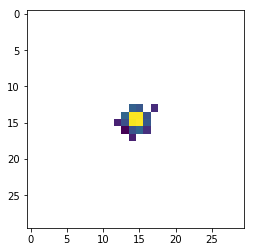

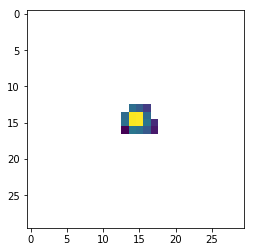

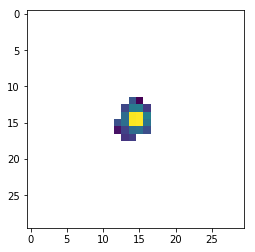

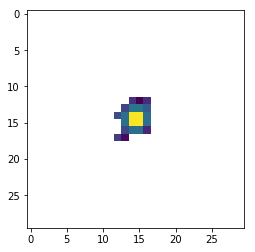

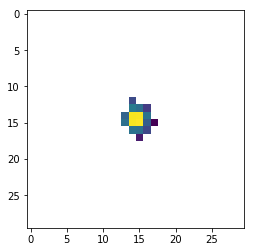

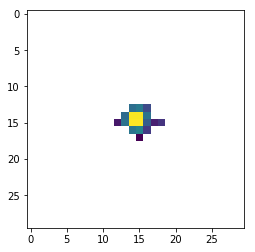

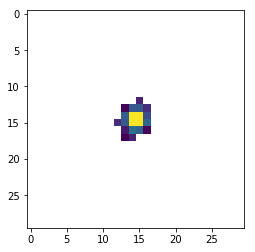

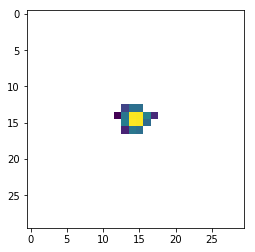

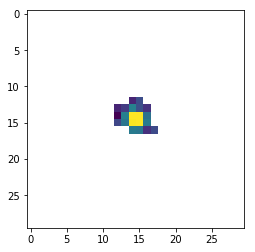

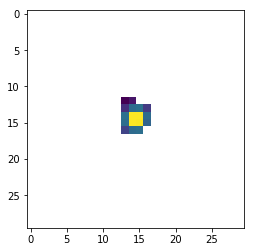

In [6]:
import scipy.misc
import matplotlib.pyplot as plt

%matplotlib inline

for i in range(10):
    plt.figure()
    plt.imshow(data[i])


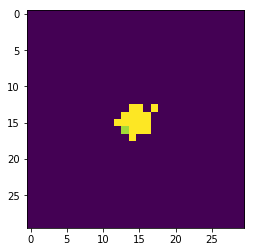

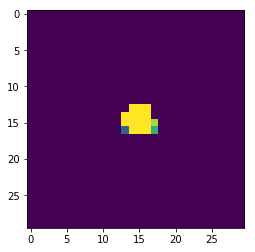

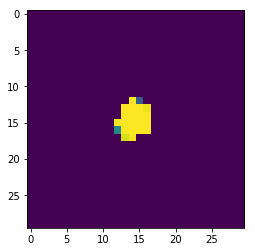

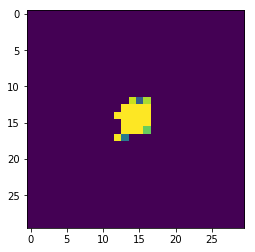

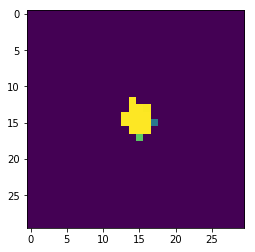

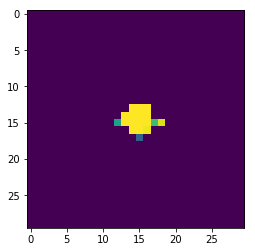

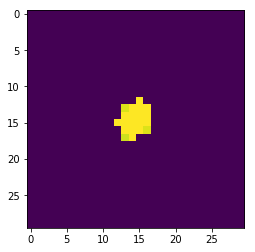

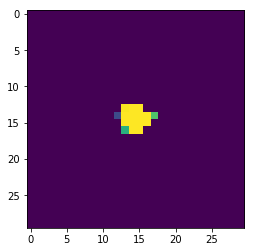

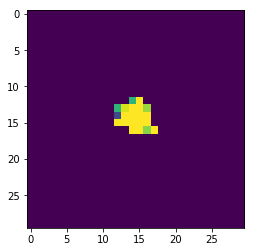

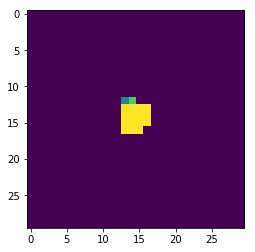

In [7]:
for i in range(10):
    plt.figure()
    plt.imshow(tanh_data[i])

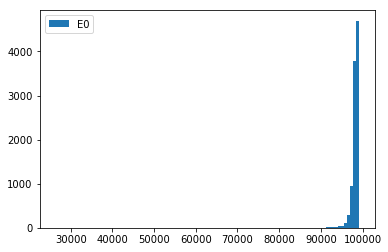

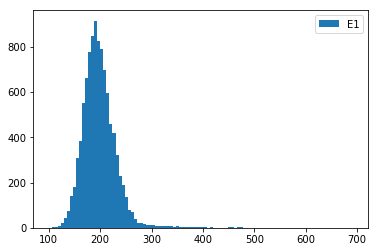

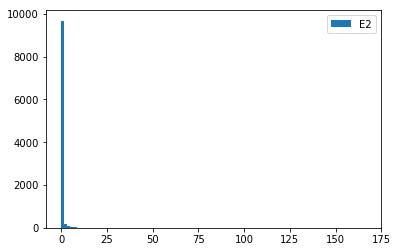

In [8]:
E, E_first, E_second = np.zeros(10000), np.zeros(10000), np.zeros(10000)

for i in range(10000):
    E[i] = np.exp(data[i][14][14]) +  np.exp(data[i][15][14]) + np.exp(data[i][14][15]) + np.exp(data[i][15][15])
    for j in range(4):
        for k in range(4):
            if (j == 0 or j == 3 or k == 0 or k == 3):
                 E_first[i] += np.exp(data[i][13+j][13+k])
            if (j == 0 or j == 7 or k == 0 or k == 7):
                 E_second[i] += np.exp(data[i][11+j][11+k])
                    
plt.hist(E, 100, label='E0')
plt.legend(loc='best')
plt.show()
plt.hist(E_first, 100, label='E1')
plt.legend(loc='best')
plt.show()
plt.hist(E_second, 100, label='E2')
plt.legend(loc='best')
plt.show()

## G

In [9]:
noise_shape = 100
img_shape = (30, 30, 1)
K.set_learning_phase(1)
leak_slope = 0.3

def build_generator_model(noise_shape):
    generator = Sequential()
    
    generator.add(layers.InputLayer(input_shape=[noise_shape]))
    generator.add(layers.Dense(10 * 10))
    generator.add(layers.Activation('relu'))
    generator.add(layers.Reshape((10, 10, 1)))
    generator.add(layers.Deconv2D(128 , kernel_size=5, activation='relu'))
    generator.add(layers.Deconv2D(64, kernel_size=4))
    generator.add(layers.Activation('relu'))
    generator.add(layers.Deconv2D(64, kernel_size=4, activation='relu'))
    generator.add(layers.Activation('relu'))
    generator.add(layers.Deconv2D(32, kernel_size=3, activation='relu'))
    generator.add(layers.Activation('relu'))
    generator.add(layers.Deconv2D(32, kernel_size=3, activation='relu'))
    generator.add(layers.Activation('relu'))
    generator.add(layers.Deconv2D(16, kernel_size=3, activation='relu'))
    generator.add(layers.Activation('relu'))
    generator.add(layers.Deconv2D(16, kernel_size=3, activation='relu'))
    generator.add(layers.Activation('relu'))
    generator.add(layers.Deconv2D(1, kernel_size=3, activation='tanh'))
    generator.summary()
    
    return generator

## D

In [17]:
def build_discriminator_model(img_shape):
    discriminator = Sequential()
    
    discriminator.add(layers.InputLayer(img_shape))
    discriminator.add(layers.Conv2D(32, kernel_size=4))
    discriminator.add(layers.LeakyReLU())
    discriminator.add(layers.Conv2D(32, kernel_size=4))
    discriminator.add(layers.LeakyReLU())
    discriminator.add(layers.AveragePooling2D(pool_size=2))
    discriminator.add(layers.Conv2D(32, kernel_size=4))
    discriminator.add(layers.LeakyReLU())
    discriminator.add(layers.Conv2D(64, kernel_size=3))
    discriminator.add(layers.LeakyReLU())
    discriminator.add(layers.Conv2D(64, kernel_size=3))
    discriminator.add(layers.LeakyReLU())
    discriminator.add(layers.AveragePooling2D(pool_size=2))
    discriminator.add(layers.Conv2D(128, kernel_size=1))
    discriminator.add(layers.LeakyReLU())
    discriminator.add(layers.Flatten())
    discriminator.add(layers.Dense(256))
    discriminator.add(layers.Activation('tanh'))
    discriminator.add(layers.Dense(2, activation=tf.nn.log_softmax))
    discriminator.summary()
    
    return discriminator

generator = build_generator_model(noise_shape)
discriminator = build_discriminator_model(img_shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 100)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 100)               10100     
_________________________________________________________________
activation_57 (Activation)   (None, 100)               0         
_________________________________________________________________
reshape_8 (Reshape)          (None, 10, 10, 1)         0         
_________________________________________________________________
conv2d_transpose_57 (Conv2DT (None, 14, 14, 128)       3328      
_________________________________________________________________
conv2d_transpose_58 (Conv2DT (None, 17, 17, 64)        131136    
_________________________________________________________________
activation_58 (Activation)   (None, 17, 17, 64)        0         
__________

In [18]:
real_data_mean = real_data.mean(axis=0)
real_data_std = real_data.std(axis=0)
stand_real_data = np.divide(real_data - real_data_mean, real_data_std, where= (real_data - real_data_mean) != 0)

In [20]:
noise = tf.placeholder(tf.float32, [None, noise_shape])
real_data = tf.placeholder(tf.float32, [None,] + list(img_shape))

discriminated_real_data = discriminator(real_data)
generated_data = generator(noise)

discriminated_generated_data = discriminator(generated_data)

########################
#discriminator training#
########################
discriminator_loss = -tf.reduce_mean(discriminated_generated_data[:, 0] + discriminated_real_data[:, 1])
discriminator_loss += tf.reduce_mean(np.abs(discriminator.layers[-1].kernel))

discriminator_optimize = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5, beta2=0.9) \
                                .minimize(discriminator_loss, var_list=discriminator.trainable_weights)

########################
###generator training###
########################
generator_loss = -tf.reduce_mean(discriminated_generated_data[:, 1])

generator_optimizer = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5, beta2=0.9) \
                                .minimize(generator_loss, var_list = generator.trainable_weights)

sess.run(tf.global_variables_initializer())

In [21]:
data = stand_real_data

def save_models():
    now = datetime.datetime.now().isoformat().split('T')[0]
    generator.save("upgrade_gen_model+{}+bn.h5".format(now))
    discriminator.save("upgrade_dis_model+{}+bn.h5".format(now))

def sample_noise_batch(bsize):
    noise = np.random.normal(size=(bsize, noise_shape)).astype('float32') 
    return noise

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs].reshape((-1, 30, 30, 1))

def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            print(images[i].shape)
            plt.imshow(images[i].reshape(30,30), interpolation="none")
        else:
            plt.imshow(images[i].reshape(30,30))
    plt.show()
    return images

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()
    
def sample_many_images(how_many):
    images = generator.predict(sample_noise_batch(bsize=how_many)).reshape(-1, 30, 30)
    return images

epoch 9950
(30, 30, 1)


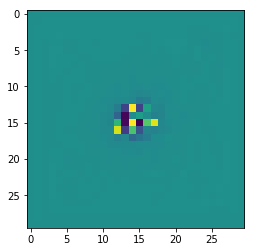

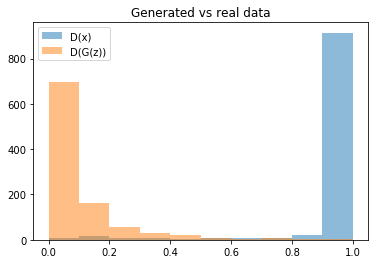

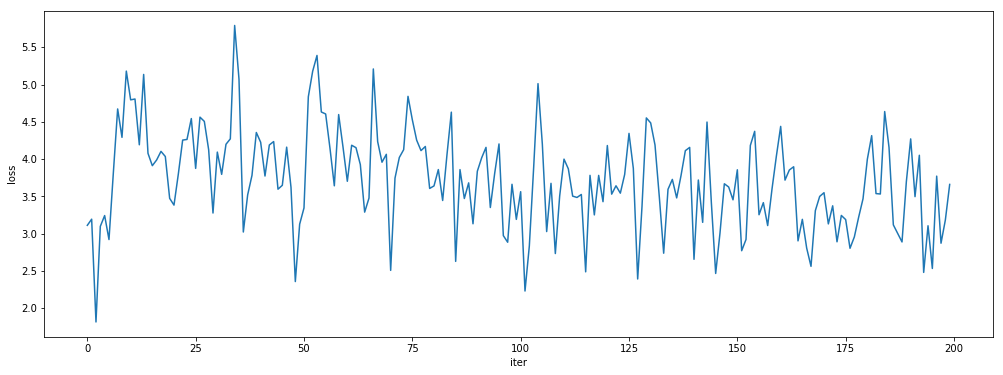

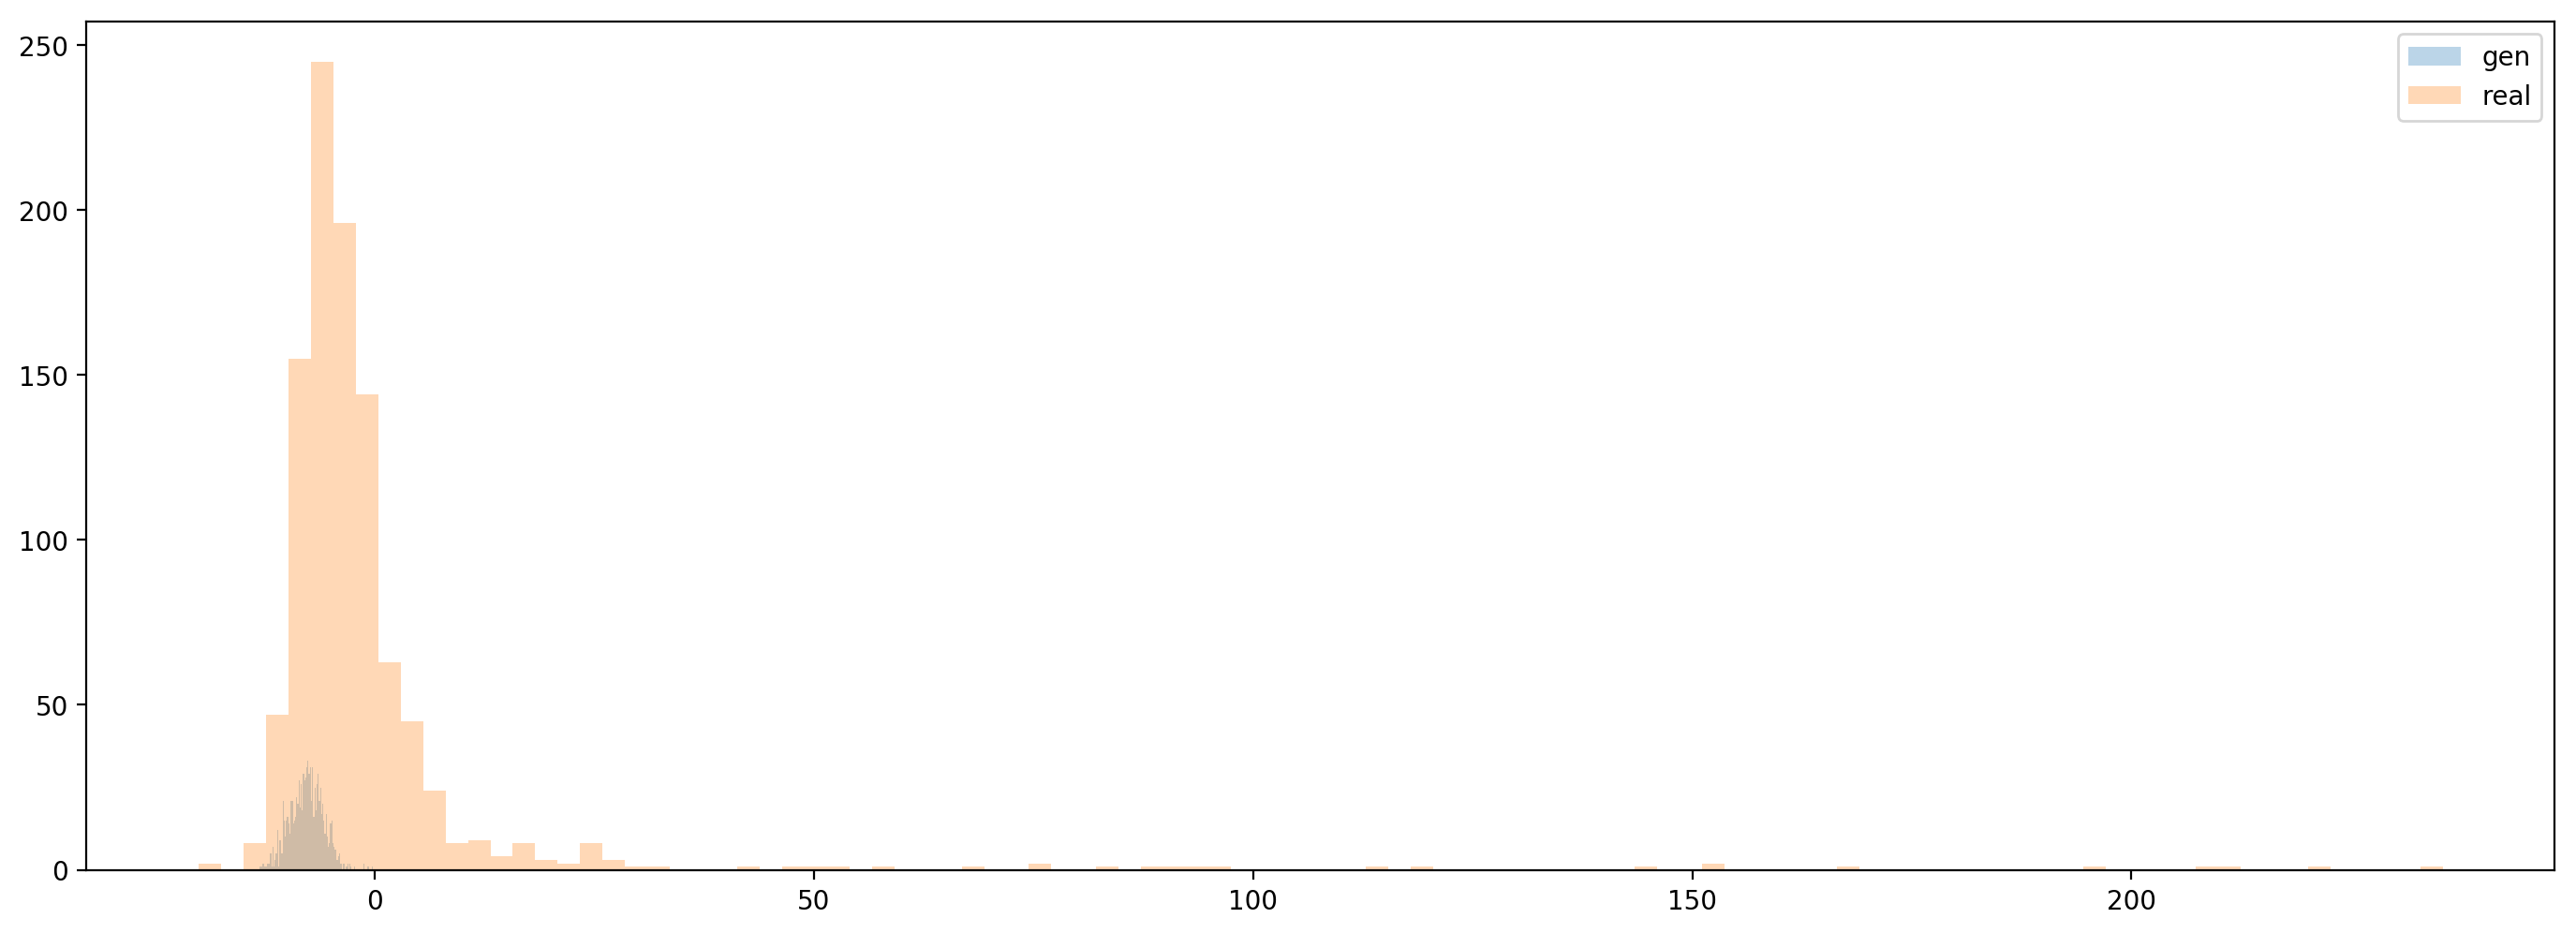

In [32]:
from IPython import display

loss_list = []
prev_img = generator.predict(sample_noise_batch(1))[0, :, :, 0]
for epoch in range(10000):
    
    feed_dict = {
        real_data : sample_data_batch(100),
        noise : sample_noise_batch(100)
    }
    
    for i in range(4):
        sess.run(discriminator_optimize, feed_dict)
    
    sess.run(generator_optimizer, feed_dict)
    
    if epoch % 50 == 0:
        display.clear_output()
        print("epoch", epoch)
        sample_images(1,1,True)
        sample_probas(1000)
        save_models()
        
        new_img = generator.predict(sample_noise_batch(1))[0, :, :, 0]
        diff = np.linalg.norm(prev_img - new_img)
        prev_img = new_img
        loss_list.append(diff)
        
        plt.figure(figsize=(17, 6))
        plt.xlabel('iter')
        plt.ylabel('loss')
        plt.plot(loss_list)
        
        sample_imgs = sample_many_images(1000)
        
        plt.figure(figsize=(17, 6), dpi=200)
        _ = plt.hist(sample_imgs.sum(axis=(1, 2)), bins=100, alpha=.3, label='gen')
        _ = plt.hist(data[:1000].sum(axis=(1, 2)), bins=100, alpha=.3, label='real')
        plt.legend()
        plt.show()

In [9]:
sample_imgs = sample_many_images(5000)
arc_sample_imgs = np.arctanh(sample_imgs)
real_sample_img = arc_sample_imgs * real_data_std + real_data_mean

central_2 = np.sum(real_sample_img[:, 14:16, 14:16], axis=(1, 2))
    
mask_4_2 = np.zeros((30, 30), dtype=bool)
mask_4_2[13:17, [13, 16]] = True
mask_4_2[[13, 16], 13:17] = True
    
central_4_2 = np.sum(real_sample_img[:, mask_4_2], axis=1)
    
mask_6_4 = np.zeros((30, 30), dtype=bool)
mask_6_4[12:18, [12, 17]] = True
mask_6_4[[12, 17], 12:18] = True
    
central_6_4 = np.sum(real_sample_img[:, mask_6_4], axis=1)

NameError: name 'sample_many_images' is not defined